In [32]:
import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# import PIL.Image as Image
import gym
from gym import spaces
import random
import pygame
from gym.envs.registration import register
from setuptools import setup
from IPython import display as ipythondisplay
import matplotlib.pyplot as plt

# font = cv2.FONT_HERSHEY_COMPLEX_SMALL

In [20]:
class GridWorld(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}
    
    def __init__(self, render_mode=None, size=5):
        self.size = size  # The size of the square grid
        self.window_size = 512  # The size of the PyGame window

        # Observations are dictionaries with the agent's and the target's location.
        # Each location is encoded as an element of {0, ..., `size`}^2, i.e. MultiDiscrete([size, size]).
        self.observation_space = spaces.Dict(
            {
                "agent": spaces.Box(0, size - 1, shape=(2,), dtype=int),
                "target": spaces.Box(0, size - 1, shape=(2,), dtype=int),
            }
        )
        
        self.action_space = spaces.Discrete(8)

        """
        The following dictionary maps abstract actions from `self.action_space` to 
        the direction we will walk in if that action is taken.
        I.e. 0 corresponds to "right", 1 to "up" etc.
        """
        self._action_to_direction = {
            0: np.array([1, 0]),    # -> right
            1: np.array([0, 1]),    # -> up
            2: np.array([-1, 0]),   # -> left
            3: np.array([0, -1]),   # -> down
            4: np.array([1, 1]),    # -> up+right
            5: np.array([-1, 1]),   # -> up+left
            6: np.array([-1, -1]),  # -> down+left
            7: np.array([1, -1]),   # -> down+right
        }
        self._agent_location = self.np_random.integers(
            0, self.size, size=2, dtype=int)
        self._target_location = self._agent_location

        self.reset();

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode
        
        self.window = None
        self.clock = None

    def _get_obs(self):
        return {"agent": self._agent_location, "target": self._target_location}

    def _get_info(self):
        return {"distance": np.linalg.norm(self._agent_location - self._target_location, ord=1)}

    def reset(self, seed=None, options=None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        # Choose the agent's location uniformly at random
        self._agent_location = self.np_random.integers(
            0, self.size, size=2, dtype=int)

        # We will sample the target's location randomly until it does not coincide with the agent's location
        self._target_location = self._agent_location
        while np.array_equal(self._target_location, self._agent_location):
            self._target_location = self.np_random.integers(
                0, self.size, size=2, dtype=int
            )

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info

    def step(self, action):
        # Map the action (element of {0,1,2,3}) to the direction we walk in
        direction = self._action_to_direction[action]
        # We use `np.clip` to make sure we don't leave the grid
        self._agent_location = np.clip(
            self._agent_location + direction, 0, self.size - 1
        )
        # An episode is done iff the agent has reached the target
        terminated = np.array_equal(
            self._agent_location, self._target_location)
        reward = 1 if terminated else 0  # Binary sparse rewards
        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, reward, terminated, info

    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode(
                (self.window_size, self.window_size))
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        pix_square_size = (
            self.window_size / self.size
        )  # The size of a single grid square in pixels

        # First we draw the target
        pygame.draw.rect(
            canvas,
            (255, 0, 0),
            pygame.Rect(
                pix_square_size * self._target_location,
                (pix_square_size, pix_square_size),
            ),
        )
        
        # Now we draw the agent
        pygame.draw.circle(
            canvas,
            (0, 0, 255),
            (self._agent_location + 0.5) * pix_square_size,
            pix_square_size / 3,
        )

        # Finally, add some gridlines
        for x in range(self.size + 1):
            # vertical
            pygame.draw.line(
                canvas,
                0,
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=3,
            )

            # horizontal
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=3,
            )

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )

    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()


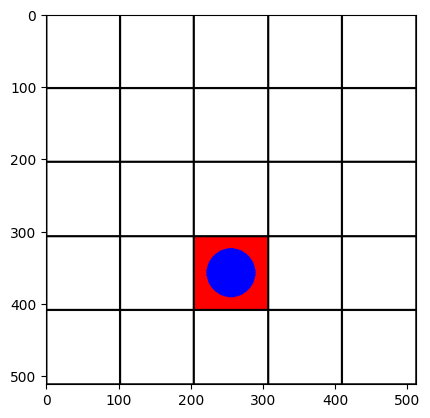

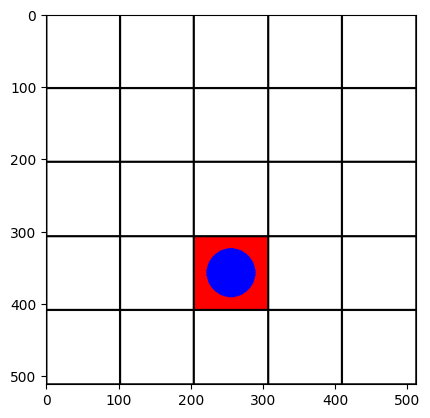

In [40]:
env = GridWorld(render_mode="rgb_array")

for _ in range(100):
    action = env.action_space.sample()
    observation, reward, terminated, info = env.step(action)

    screen = env.render()
    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

    if terminated:
        break;

env.close()